In [68]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [69]:
%load_ext autoreload
%autoreload 2

In [372]:
import numpy
import pandas as pd
import matplotlib.pyplot as pl

import theano
import theano.tensor as T

In [412]:
data = pd.read_pickle('/home/hudson/experiments/prostate.df')

train_set_y = (data.values[:, -1] == 'tumor')
print train_set_y.shape
print train_set_y[-1]
train_set_x = data.values[:, :-1]
print train_set_x.shape
n_genes = train_set_x.shape[1]
print n_genes

train_set_x = train_set_x[:100].astype(float)
train_set_y = train_set_y[:100].astype(float).reshape((100,1))
batch_size = 20
n_batches = len(train_set_y)/batch_size
print (train_set_x)[0]
print (train_set_y)[0], (train_set_y)[-1]
print len(train_set_y), n_batches

train_set_x = theano.shared(value=train_set_x, name='tx', borrow=True)
train_set_y = theano.shared(value=train_set_y, name='ty', borrow=True)

(102,)
True
(102, 12533)
12533
[-11.39999962   2.70000005   0.60000002 ...,  19.29999924 -39.5
  37.29999924]
[ 0.] [ 1.]
100 5


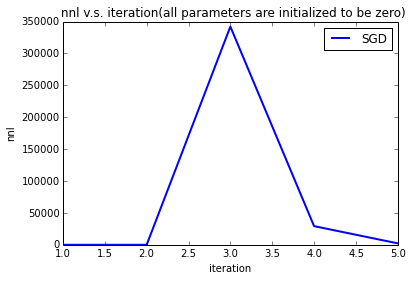

In [420]:
# all parameters are initialized to be zero; 
x = T.matrix("x")
y = T.matrix("y")

w = theano.shared(np.zeros((n_genes,1)), name="w")
#w = theano.shared(rng.randn(n_genes), name="w")

# initialize the bias term
b = theano.shared(0., name="b")

l = T.dot(x, w) + b
p = T.nnet.sigmoid(l)
nnl = T.mean(-y * T.log(p) - (1-y) * T.log(1-p))

gw, gb = T.grad(nnl, [w, b])   

              
# Compile
learning_rate = 1e-2  #0.1  # #
updates = [(w, w - learning_rate * gw), (b, b - learning_rate * gb)]

index = T.lscalar()
train_model = theano.function(
    inputs=[index],
    outputs=nnl,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
)

# Train
training_steps = np.arange(1, 50)
nnls = np.zeros(len(training_steps))
for i, d in enumerate(training_steps):
    err = train_model(i)
    nnls[i] = np.mean(err)
#print nnls

plt.title(' nnl v.s. iteration(all parameters are initialized to be zero)')
pl.plot(training_steps, nnls, lw=2, label = 'SGD')
pl.legend()
pl.xlabel('iteration')
pl.ylabel('nnl')

pl.show()

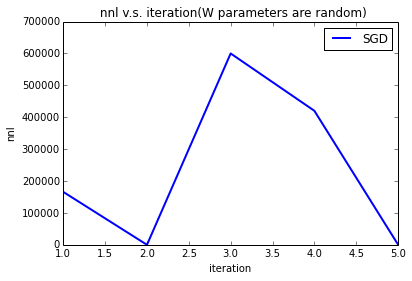

In [419]:
# all parameters are initialized to be zero; 
x = T.matrix("x")
y = T.matrix("y")

#w = theano.shared(np.zeros((n_genes,1)), name="w")
w = theano.shared(np.random.rand(n_genes,1), name="w")

# initialize the bias term
b = theano.shared(0., name="b")

l = T.dot(x, w) + b
p = T.nnet.sigmoid(l)
nnl = T.mean(-y * T.log(p) - (1-y) * T.log(1-p))

gw, gb = T.grad(nnl, [w, b])   

              
# Compile
learning_rate = 1e-2  #0.1  # #
updates = [(w, w - learning_rate * gw), (b, b - learning_rate * gb)]

index = T.lscalar()
train_model = theano.function(
    inputs=[index],
    outputs=nnl,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
)

# Train
training_steps = np.arange(1, 50)
nnls = np.zeros(len(training_steps))
for i, d in enumerate(training_steps):
    err = train_model(i)
    nnls[i] = np.mean(err)
#print nnls

plt.title(' nnl v.s. iteration(W parameters are random)')
pl.plot(training_steps, nnls, lw=2, label = 'SGD')
pl.legend()
pl.xlabel('iteration')
pl.ylabel('nnl')

pl.show()


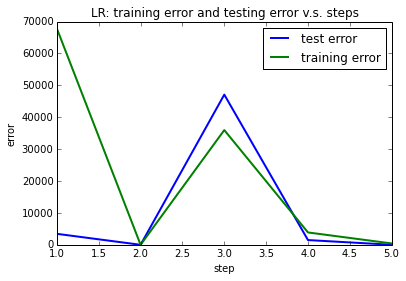

In [406]:
# conduct 10-fold cross validatin
from sklearn.cross_validation import KFold
n_folds = 10
#10 fold cross-validation
kf = KFold(100, n_folds=n_folds)

training_steps = np.arange(1, 50)
avg_train_err = np.zeros(len(training_steps))
avg_test_err = np.zeros(len(training_steps))
for i, d in enumerate(training_steps):
    train_errors = np.zeros(n_folds)
    test_errors = np.zeros(n_folds)
    index = 0
    for train_index, test_index in kf:
        X_train, X_test = train_set_x[train_index], train_set_x[test_index]
        y_train, y_test = train_set_y[train_index], train_set_y[test_index]

        cost_val  = train_model(i)
        train_errors[index] = np.mean(cost_val)           
        
        cost_val  = train_model(i)
        test_errors[index] = np.mean(cost_val)  
        index += 1
    avg_train_err[i] = np.mean(train_errors)
    avg_test_err[i] = np.mean(test_errors)

#print avg_train_err
#print avg_test_err

plt.title('LR: training error and testing error v.s. steps')
pl.plot(training_steps, avg_test_err, lw=2, label = 'test error')
pl.plot(training_steps, avg_train_err, lw=2, label = 'training error')
pl.legend()
pl.xlabel('step')
pl.ylabel('error')

pl.show()

0 0.513615102861
('w is', 12533, 12532)
1 0.589187995943
('w is', 12533, 12532)
2 0.654817208304
('w is', 12533, 12533)
3 0.69862974806
('w is', 12533, 12533)
4 0.84364226571
('w is', 12533, 12533)
[ 0.5136151   0.589188    0.65481721  0.69862975  0.84364227]


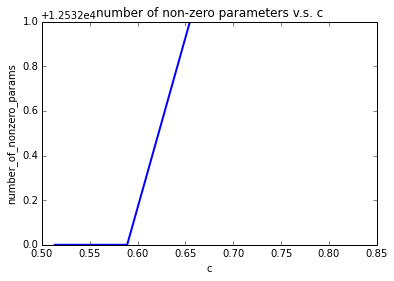

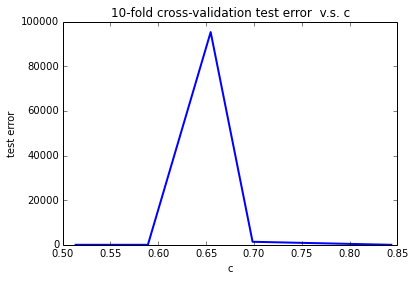

In [482]:
#Add L1-regularization to your model

# -number of non-zero parameters v.s. c
#- 10-fold cross-validation test error v.s. c 

# all parameters are initialized to be zero; 
x = T.matrix("x")
y = T.matrix("y")

w = theano.shared(np.zeros((n_genes,1)), name="w")
#w = theano.shared(np.random.rand(n_genes,1), name="w")

# initialize the bias term
b = theano.shared(0., name="b")

l = T.dot(x, w) + b
p = T.nnet.sigmoid(l)
nnl = T.mean(-y * T.log(p) - (1-y) * T.log(1-p))

             
# Compile
learning_rate = 1e-2  #0.1  # #
updates = [(w, w - learning_rate * gw), (b, b - learning_rate * gb)]

c_interation = np.sort(np.random.rand(5)[::-1]) #np.arange(1, 10)
avg_test_err = np.zeros(len(c_interation))
number_of_nonzero_params = np.zeros(len(c_interation))
learning_rate = 1e-2  #0.1  # #  

for i, d in enumerate(c_interation):
    print i,d
    

    nnl_opt = nnl + d * (w ** 2).sum()   
    gw, gb = T.grad(nnl_opt, [w, b])   
     
    updates = [(w, w - learning_rate * gw), (b, b - learning_rate * gb)]

    index = T.lscalar()
    train_model = theano.function(
        inputs=[index],
        outputs=nnl,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
    )      
    
    
    test_errors = np.zeros(n_folds)
    index = 0
    for train_index, test_index in kf:
        X_train, X_test = train_set_x[train_index], train_set_x[test_index]
        y_train, y_test = train_set_y[train_index], train_set_y[test_index]     
        
        cost_val  = train_model(i)
        test_errors[index] = np.mean(cost_val)  
        index += 1
    avg_test_err[i] = np.mean(test_errors)
    
    print('w is', len(w.get_value()), len((w.get_value().nonzero())[0]))
    #print("b is %s", b.get_value())
    
    number_of_nonzero_params[i] = len((w.get_value().nonzero())[0])



print c_interation

plt.title('number of non-zero parameters v.s. c')
pl.plot(c_interation, number_of_nonzero_params, lw=2, label = 'number_of_nonzero_params')
#pl.legend()
pl.xlabel('c')
pl.ylabel('number_of_nonzero_params')
pl.show()

plt.title('10-fold cross-validation test error  v.s. c')
pl.plot(c_interation, avg_test_err, lw=2, label = 'test error')
#pl.legend()
pl.xlabel('c')
pl.ylabel('test error')

pl.show()